# Setup

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences, plot_history
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation, expectation_function
from FittedModels.Models.FlowModel import FlowModel
import matplotlib.pyplot as plt

In [3]:
from TargetDistributions.base import BaseTargetDistribution

In [4]:
torch.set_default_dtype(torch.float64)

In [5]:
class Triangle_MoG(BaseTargetDistribution, nn.Module):
    # Mog with hard coded mean and cov to form a triangle
    def __init__(self, loc_scaling=5, cov_scaling=1):
        super(Triangle_MoG, self).__init__()
        dim = 2
        locs = torch.stack([torch.tensor([1.0, 0.0]), torch.tensor([0.0, 1.0]), torch.tensor([-1.0, 0.0])])*loc_scaling
        covs = torch.stack([torch.eye(dim)*cov_scaling]*3)
        self.register_buffer("locs", locs)
        self.register_buffer("covs", covs)
        self.register_buffer("cat_probs", torch.tensor([0.2, 0.6, 0.2]))

    @property
    def get_distribution(self):
        mix = torch.distributions.Categorical(self.cat_probs)
        com = torch.distributions.MultivariateNormal(self.locs, self.covs)
        return torch.distributions.MixtureSameFamily(mixture_distribution=mix, component_distribution=com)

    def log_prob(self, x):
        return self.get_distribution.log_prob(x)

    def sample(self, shape=(1,)):
        return self.get_distribution.sample(shape)

In [6]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
target = Triangle_MoG(loc_scaling=5, cov_scaling=1)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # print twice to make sure estimates are resonably close

tensor(27.0007)
tensor(27.0173)


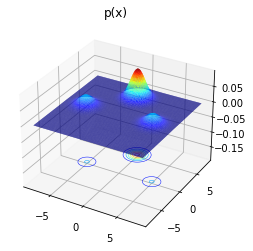

In [7]:
width = 8
fig = plot_distribution(target, bounds=[[-width, width], [-width, width]])

In [9]:
epochs = 1000
batch_size = int(1e2)
dim = 2
n_samples_estimation = int(1e6)
KPI_n_samples = int(1e4)

# DReG

In [9]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

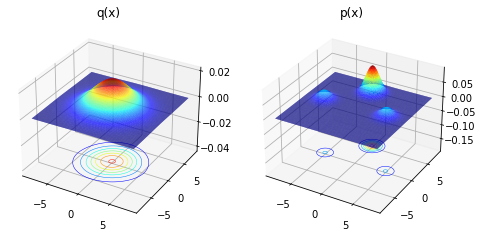

In [10]:
width = 8
fig_before_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

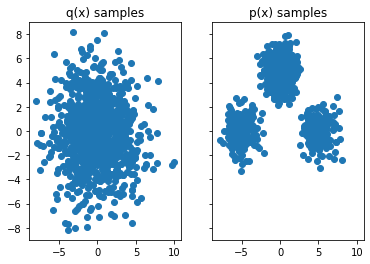

In [11]:
samples_fig_before = plot_samples(tester) 

In [12]:
history = tester.train(epochs, batch_size=batch_size, KPI_batch_size=KPI_n_samples,
                       clip_grad=True, max_grad_norm=1)

loss: -0.6093068752079027, mean log p_x -5.7998911033035325: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:09<00:00,  1.09s/it]


In [13]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 27.00068092915432 
estimate before training is 26.96192585851744 
estimate after training is 27.003831527156205 
effective sample size before is 0.09806445919695442
effective sample size after train is 0.49622848211721604
variance in weights is 1.0152017463919928e-12


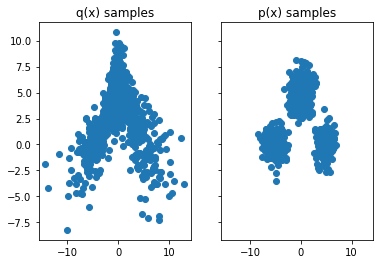

In [14]:
samples_fig_after = plot_samples(tester)

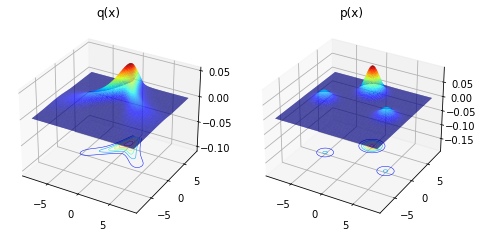

In [15]:
width = 8
fig_after_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

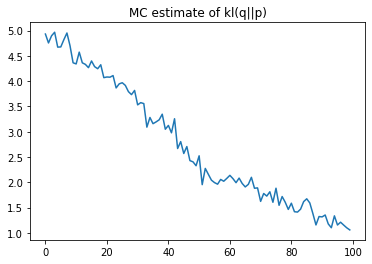

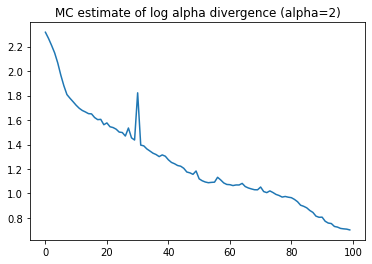

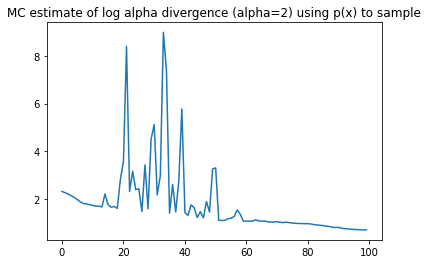

In [16]:
plot_divergences(history)

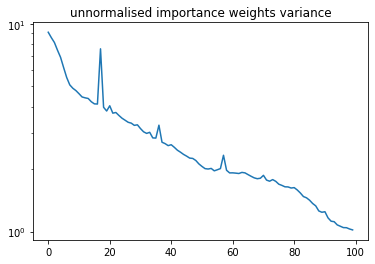

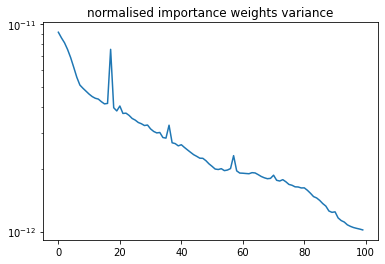

In [17]:
plot_sampling_info(history)

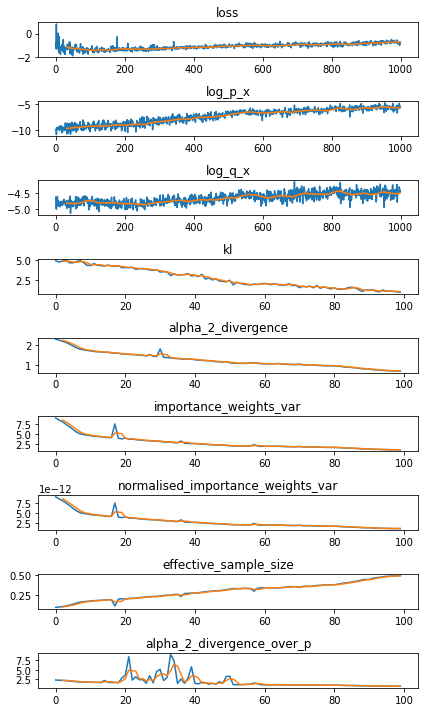

In [18]:
hist_plot = plot_history(history)

# KL

In [10]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

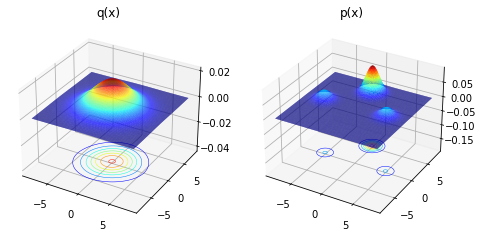

In [11]:
width = 8
fig_before_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

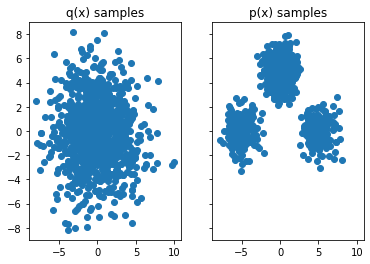

In [12]:
samples_fig_before = plot_samples(tester) 

In [13]:
history = tester.train(epochs, batch_size=batch_size, KPI_batch_size=KPI_n_samples, 
                       clip_grad=True, max_grad_norm=1)

 ... (more hidden) ...


In [14]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 27.00068092915432 
estimate before training is 26.96192585851744 
estimate after training is 26.683420572661184 
effective sample size before is 0.09806445919695442
effective sample size after train is 0.0009328072577314212
variance in weights is 1.0710338963700971e-09


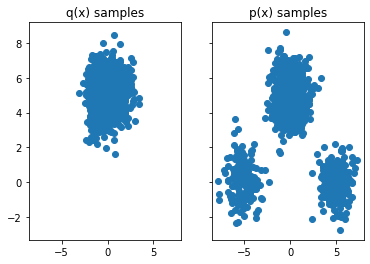

In [15]:
samples_fig_after = plot_samples(tester)

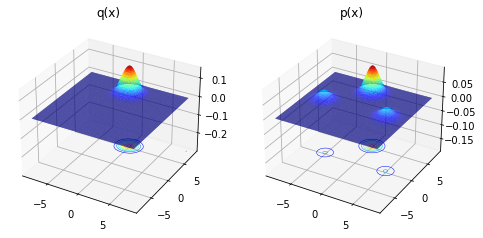

In [16]:
width = 8
fig_after_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

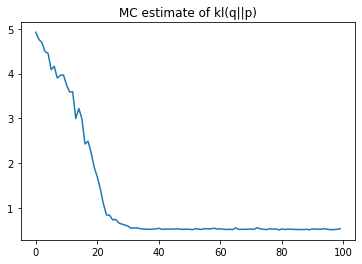

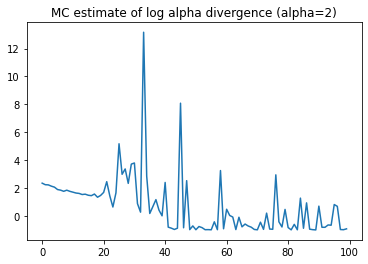

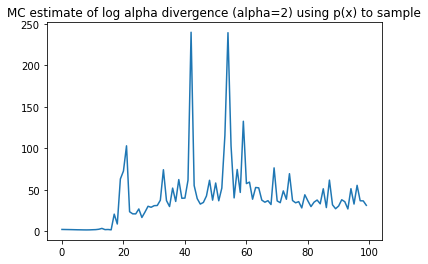

In [17]:
plot_divergences(history)

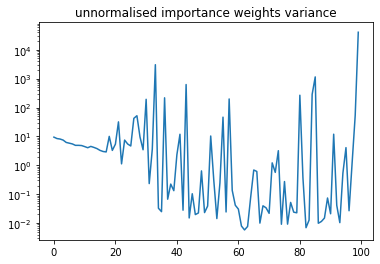

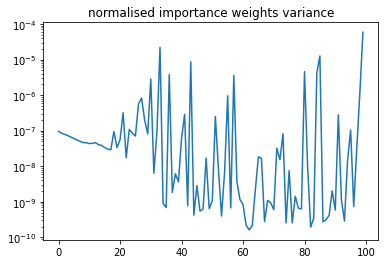

In [18]:
plot_sampling_info(history)

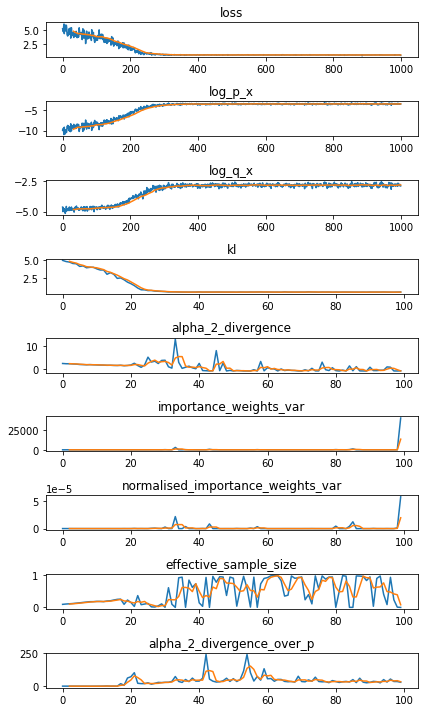

In [19]:
hist_plot = plot_history(history)

In [25]:
info['normalised_sampling_weights'].max(), info['normalised_sampling_weights'].min()

(tensor(0.0268), tensor(5.3286e-07))

## let's calculate the recalculate the importance weights for inspection

In [54]:
with torch.no_grad():
    x_samples, log_q_x = tester.learnt_sampling_dist(int(1e6))

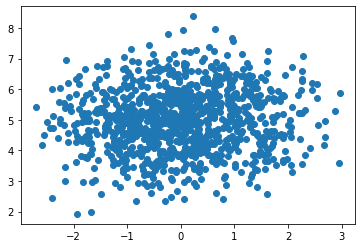

In [56]:
plt.scatter(x_samples[:1000, 0].detach(), x_samples[:1000, 1].detach())

In [57]:
log_p_x = tester.target_dist.log_prob(x_samples)

In [58]:
log_w = log_p_x - log_q_x

In [34]:
log_w.max(), log_w.min()

(tensor(9.6677), tensor(-1.0565))

In [61]:
max_index = torch.argmax(log_w)
max_index

tensor(219290)

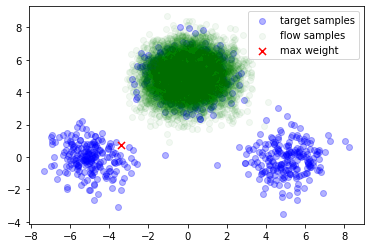

In [78]:
target_samples = tester.target_dist.sample((1000,)).detach()
plt.scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.3, c="b")
plt.scatter(x_samples[:10000, 0].detach(), x_samples[:10000, 1].detach(), alpha=0.05, c="g")
plt.scatter(x_samples[max_index, 0], x_samples[max_index, 1], c="r", marker="x", s=50)
plt.legend(["target samples", "flow samples", "max weight"])